In [1]:
import matplotlib.pyplot as plt
import numpy
import csv
import pandas
import scipy.optimize as optimize
import numpy as np

import seaborn as sns
sns.set(style='white', font_scale = 2)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

Script for processing output data from a JASCO J-1500 refolding run. This script assumes that the output files have been converted to .csv outputs, that spectra were collected at 5 ˚C, 25 ˚C, 35 ˚C, 55 ˚C, 75 ˚C and 95 ˚C, and run at a melting rate of 1 ˚C/min.

Variables that need to be updated are the name of the protein, its concentration and its size (in amino acids), as well as the pathlength of the cuvette. This is to ensure accurate calculation of MRE.

In [2]:
melt_spectra_file = 'melt spec.csv'
melt_222_file = 'melt a222.csv'
refold_spectra_file = 'refold spec.csv'
refold_222_file = 'refold a22.csv'

#Protein name for plots
protein = 'Protein'
concentration = 20.00 #in uM
no_res = 112 #number of residues in protein
n = no_res-1
pathlength = 1 #cuvette pathlength in mm

#temperatures that spectra were recorded at:
min_temp = 5 #minimum temperature
max_temp = 95 #maximum temperature

In [3]:
#Need to remove top 20 lines from spectra files and 16 from melt files

In [4]:
def delete_lines(filename,no_lines,comma):
    with open(filename,'r+')as f:
        g = open('cropped_'+filename,'w+')
        count = 1
        d=f.readlines()
        f.seek(0)
        for i in d:
            if count > no_lines:
                #print(i)
                g.write(i)
            count = count+1
            if count == no_lines+1:
                if comma == 1:  #removing comma from first line in melt file
                    g.write(i[1:])
                elif comma == 0:
                    g.write(i)

In [5]:
# Remove non-relevant info from top of csv, and comma that stops spectra files being processed correctly
delete_lines(melt_222_file,17,0)
delete_lines(refold_222_file,17,0)
delete_lines(melt_spectra_file,21,1)
delete_lines(refold_spectra_file,21,1)

# Spectra Plot

In [6]:
#spectra have 60 and a header column of the first row
#melt_spectra = pandas.read_csv(mspec_file, nrows = 61)\
melt_spectra = pandas.read_csv('cropped_'+ melt_spectra_file, nrows = 61)
refold_spectra = pandas.read_csv('cropped_'+ refold_spectra_file, nrows = 61)

## MRE calculation

In [7]:
def mre(mdeg):
    return (mdeg*1000000)/(pathlength*concentration*n)

### Plot graphs 

melt
refold


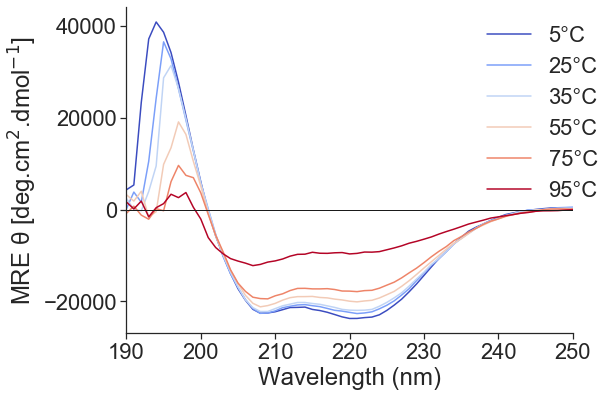

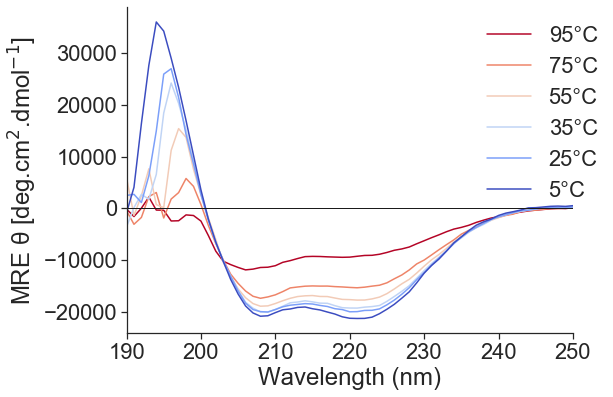

In [8]:
print('melt')

ax1=mre(melt_spectra).plot(cmap=plt.cm.get_cmap('coolwarm'), figsize = (8,6))
ax1.axhline(y=0, linewidth=1, color ='k')
ax1.set(ylabel= r'MRE θ [deg.cm$^{2}$.dmol$^{-1}$]')
ax1.set(xlabel ='Wavelength (nm)')
#ax1.set(title = protein + ' melt')
ax1.legend(['5°C','25°C','35°C','55°C','75°C','95°C'],frameon=False,bbox_to_anchor=(0.90, 0.6, 0.2, 0.15), loc='right')
#ax1.legend()

sns.despine()

print('refold')
ax2 =mre(refold_spectra).plot(cmap=plt.cm.get_cmap('coolwarm_r'), figsize = (8,6))
ax2.axhline(y=0, linewidth=1, color ='k')
ax2.set(ylabel ='MRE')
ax2.set(ylabel= r'MRE θ [deg.cm$^{2}$.dmol$^{-1}$]')
ax2.set(xlabel ='Wavelength (nm)')
#ax2.set(title = protein + ' refold')
ax2.legend().set_visible(False)
ax2.legend(['95°C','75°C','55°C','35°C','25°C','5°C'],frameon=False,bbox_to_anchor=(0.9, 0.6, 0.2, 0.15), loc='right')

sns.despine()

# Melt Plot

In [9]:
#melts have 90 data points and no header column 
melt_222 = pandas.read_csv('cropped_'+ melt_222_file, header=None, names = ['Temp','CD (mdeg)','HT (V)','Abs'], nrows=90)
refold_222 = pandas.read_csv('cropped_'+ refold_222_file, header=None, names = ['Temp','CD (mdeg)','HT (V)','Abs'], nrows=90)

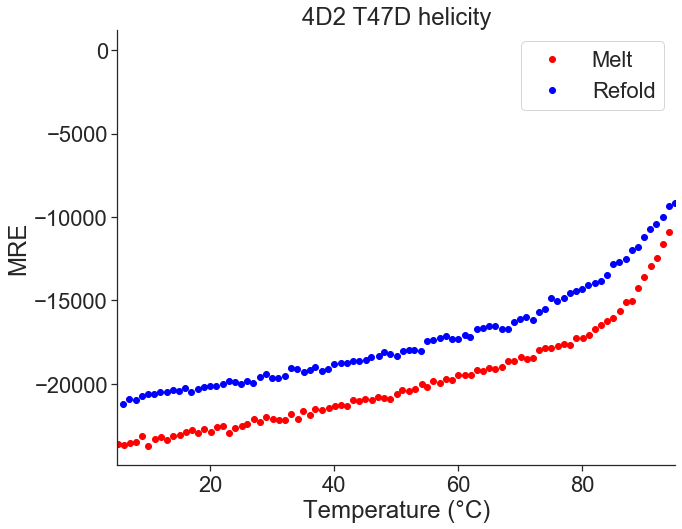

In [10]:
plt.figure(figsize = (10,8))

plt.plot(melt_222.take([0],axis=1),mre(melt_222.take([1],axis=1)),'o',color='red', label = 'Melt')
plt.plot(refold_222.take([0],axis=1),mre(refold_222.take([1],axis=1)),'o', color = 'blue', label = 'Refold')
plt.plot(0,0)
plt.title(protein + ' helicity')
plt.ylabel('MRE')
plt.xlabel('Temperature (°C)')
plt.xlim(min_temp,max_temp)
plt.legend()

sns.despine()

In [11]:
## Interpolate the points to form a line

In [12]:
from scipy.interpolate import interp1d

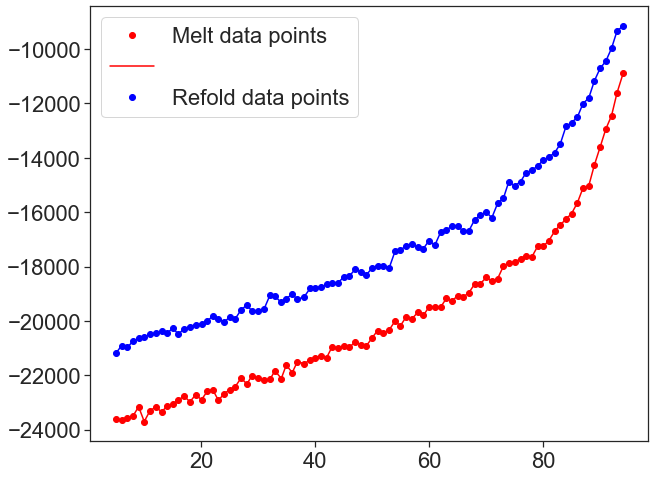

In [13]:
xdata = melt_222.take([0],axis=1)
rydata = mre(refold_222.take([1],axis=1))
mydata = mre(melt_222.take([1],axis = 1))

mydata = mydata.rename(columns={'CD (mdeg)':''})
rydata = rydata.rename(columns={'CD (mdeg)':''})
xdata = xdata.rename(columns={'Temp':''})

xdata = np.array(xdata, dtype=np.float32)
mydata = np.array(mydata, dtype=np.float32)
rydata = np.array(rydata, dtype=np.float32)

my = np.asarray(mydata).squeeze()
ry = np.asarray(rydata).squeeze()
x = np.asarray(xdata).squeeze()
rx = np.flip(x)

mf = interp1d(x,my)
rf = interp1d(rx,ry)

plt.figure(figsize=(10,8))

plt.plot(x,my,'o',x,mf(x),'k-',color='red')
plt.plot(rx,ry,'bo',x,rf(x),'k-',color='blue')

plt.legend(['Melt data points','', 'Refold data points'])

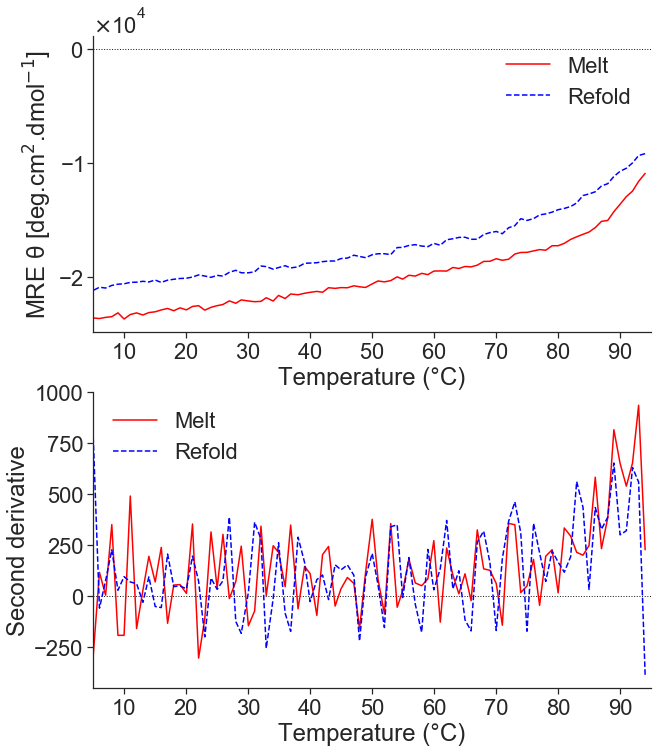

In [14]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

melt_spl = IUS(x, my)
melt_der= melt_spl.derivative()

up_ry = np.flip(ry)
refold_spl = IUS(x,up_ry)
refold_der = refold_spl.derivative()

plt.figure(figsize=(10,12))

plt.subplot(2, 1, 2)
plt.plot(x,melt_der(x),'-',color='red')
plt.plot(rx,refold_der(rx),'--',color='blue')
plt.xlim(5,95)
plt.ylabel('Second derivative')
plt.hlines(0,5,95,lw=1,linestyle='dotted')
plt.xticks(np.arange(10,100, step=10))
plt.legend(['Melt','Refold'],frameon=False)
plt.xlabel('Temperature (°C)')

plt.subplot(2, 1, 1)
plt.plot(x,my,'-',color='red')
plt.plot(rx,ry,'--',color='blue')
plt.xlim(5,95)
plt.xticks(np.arange(10,100, step=10))
plt.yticks(np.arange(0,-90001, step = -10000))

plt.ticklabel_format(style ='sci',scilimits = (0,3),useMathText=True)
plt.hlines(0,5,95,lw=1,linestyle='dotted')
plt.ylabel(r'MRE θ [deg.cm$^{2}$.dmol$^{-1}$]')
plt.xlabel('Temperature (°C)')
plt.legend(['Melt','Refold'],frameon=False)

sns.despine()

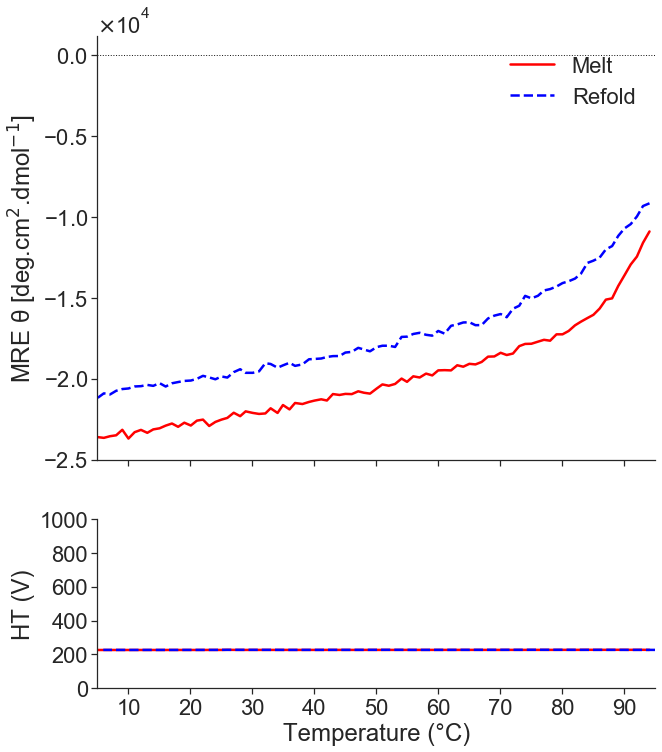

In [15]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 2]},figsize=(10,12))

a0.ticklabel_format(style ='sci',scilimits = (0,3),useMathText=True)
a0.plot(x,my,'-',color='red', label = 'Melt',linewidth=2.5)
a0.plot(rx,ry,'--',color='blue', label = 'Refold',linewidth=2.5)
a0.set_xlim(5,95)
a0.hlines(0,5,95,lw=1,linestyle='dotted')
a0.set_xticks(np.arange(10,100, step=10))
a0.set_yticks(np.arange(0,-25001, step = -5000))
a0.set_ylabel(r'MRE θ [deg.cm$^{2}$.dmol$^{-1}$]')
a0.legend()
a0.legend(['Melt','Refold'],frameon=False)

a1.plot(melt_222.take([0],axis=1),melt_222.take([2],axis=1), color='red',linewidth=2.5)
a1.plot(refold_222.take([0],axis=1),refold_222.take([2],axis=1),'--', color = 'blue',linewidth=2.5)
a1.set_ylabel('HT (V)')
a1.set_xlabel('Temperature (°C)')
a1.set_xlim(min_temp,max_temp)
a1.set_yticks(np.arange(0,1001, step = 200))
a1.set_xticks(np.arange(10,100, step=10))
a1.set_ylim(0,1000)

plt.setp(a0.get_xticklabels(), visible=False)


sns.despine()